# 5. Анализируем обзоры фильмов на IMDB

---

По материалам курсов https://course.fast.ai/

*переведено, дополнено, адаптировано, расширено https://vk.com/lambda_brain*
*февраль 2020*

---

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## Готовим исходные данные

Оригинальный [датасет](http://ai.stanford.edu/~amaas/data/sentiment/) создан Andrew Maas и содержит 100,000 обзоров на IMDB. 25,000 из них -- обучающая выборка, каждый обзор размечен как позитивный или негативный. Другие 25,000 -- тестовая выборка (надо отметить, что позитивные и негативные отзывы достаточно чётко различаются). Оставшиеся 50,000 никак не размечены, и мы можем использовать их произвольно.

*Работа с данным крупным датасетом потребует ощутимого времени -- десятков минут или единичных часов.*


Общая схема такая, что

сперва мы обрабатываем исходные сырые данные минимумом кода,

затем создаём так называемую **языковую модель**
https://habr.com/ru/company/wunderfund/blog/318454/
которая задаёт некоторое распределение вероятностей на множестве предложений (вероятность следующего слова на основе предыдущих) -- она уже была обучена, и остаётся выполнить fine-tuning её коэффициентов,   

и наконец на основе **кодировщика** этой модели (см. далее) создаём итоговый классификатор.



In [0]:
# fast.ai поддерживает датасет IMDB как стандартный
path = untar_data(URLs.IMDB_SAMPLE) # сначала загрузим ограниченную версию IMDB на 1000 отзывов 
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

IMDB_SAMPLE -- это только один текстовый csv-файл. Посмотрим, что у него внутри.

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Всё удобно организовано -- есть метка позитивный/негативный, есть сам отзыв, и есть признак, относится ли отзыв к обучающей или тестовой выборкам.

In [0]:
df['text'][1] # пример позитивного отзыва

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Можно сразу использовать класс `TextDataBunch` -- базовый датабанч, предназначенный для сегментации текста (хотя корректнее говорить о классификации текстов). По умолчанию он будет игнорировать признак is_valid (деление на обучающую и тестовую выборки можно реализовать механизмом самого **fast.ai**).

Если данные организованы по другому (разбиты по каталогам), надо использовать другие методы этого класса.

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

На первый взгляд может показаться, что работа с текстом должна происходить быстрее, чем с огромными изображениями, но это не так. Изображения можно сразу загружать в модель, так как они чаще всего представляются просто массивом значений пикселов, которые кодируются вещественным значением между 0 и 1. Однако осмысленный текст составляется не просто из букв, а из слов, и напрямую применять к ним математический аппарат глубокого обучения нельзя. Сперва слова надо преобразовать в числа, причём по какому-то формальному и достаточно действенному способу. Классических подходов здесь два: это **токенизация** (или сегментация, абзацы на предложения, предложения на слова) и **оцифровка** (numericalization). Класс `TextDataBunch` поддерживает оба эти подхода.


In [0]:
data_lm.save()

Если процесс загрузки из csv-файла занимает длительное время, результат можно сохранить, чтобы в следующий раз просто быстро восстановить.


In [0]:
data = load_data(path)

### Токенизация

Самый первый шаг токенизации -- это разбиение "сырых" исходных предложений на слова, или **токены**.
Для этого:
- учитываем пунктуацию;
- учитываем, что некоторые слова -- это аббревиатуры или иные сокращения нескольких слов;
- учитываем, что обычный текст может быть перемешан с чем-то сторонним (например, научными формулами или кодом программы).

Класс `TextClasDataBunch` готовит данные в формате, удобном для текстового классификатора.

Результат токенизации можно увидеть наглядно:

In [0]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


Для большей наглядности тексты усечены до 100 токенов. Видно, что исходные тексты не просто были разбиты на слова через пробелы и знаки пунктуации -- добавлены дополнительные пробелы, прописные буквы переведены в строчные, различные английские сокращения выделены в токены, все дополнительные "нелитературные" символы удалены, а также добавлен ряд служебных токенов, которые начинаются с xx. Служебные токены заменяют непонятные слова или уточняют разметку текста.

### Оцифровка (numericalization)

Получив токены из исходного текста, мы преобразуем их в числа. Для этого создаётся список всех слов (словарь) с максимальным размером на 60,000 слов. Причём в него попадают только те слова, которые встречаются хотя бы два раза, а остальные заменяются на токен "незнакомости" `UNK`.
Словарь (связь токенов с их числовыми индексами) хранится в атрибуте `vocab` нашего датасета, а доступ к нему осуществляется через свойство `itos` (из int в string).

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

То, что хранится непосредственно в нашем датасете, это токенизированный текст:

In [0]:
data.train_ds[0][0] # текст первого отзыва


Text xxbos xxmaj forget the campy ' religious ' movies that have xxunk the television / film market ... this movie has a real feel to it . xxmaj while it may be deemed as a movie that has cheap emotional draws , it also has that message of xxunk , and overall good morals . xxmaj however , i did not like the lighting in this movie ... for a movie dealing with such subject matter , it was too bright . i felt it took away from the overall appeal of the movie , which is almost an xxunk sin , but the recognizable cast , and their performances counteract this xxunk . 
 
  xxmaj definitely worth seeing ... buy the xxup dvd .

In [0]:
data.train_ds[0][1] # категория первого отзыва

Category positive

Однако "внутри" это всё будут числа:

In [0]:
data.train_ds[0][0].data[:10]

array([   2,    5,  832,    9, 2012,   64, 1368,   64,  124,   20])

In [0]:
data.train_ds[0][1].data

1

### Используйте более мощный API

Для обработки текстов в **fast.ai** доступен мощный и гибкий API, который позволяет спускаться к конкретным шагам обработки тестов и при необходимости их пераметризовать, изучать промежуточные результаты. Например, мы можем разбивать датасет на обучающую и тестовую выборки случайно, не учитывая флажок, заданный в csv-файле.


In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text') # список из 1000 текстовых отзывов
                .split_from_df(col=2) # разделение на обучающую и тестовую выборки
                .label_from_df(cols=0) # токенизация
                .databunch()) # перевод в формат датабанча
print(data)

## Языковая модель

В общем случае обработка естественных текстов может потребовать существенных ресурсов GPU, и эта нагрузка может регулироваться размером одного пакета для обработки.

In [0]:
bs = 48

Захватим оригинальный датасет целиком (ранее мы использовали его ограниченную версию IMDB_SAMPLE).

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

In [0]:
(path/'train').ls()

Структура датасета IMDB по своему устройству аналогична структуре датасета ImageNet. Единственное отличие, что добавился каталог `unsup` на уровне каталогов `train` и `test`, который содержит неразмеченные данные.

Как и в случае с примерами по машинному зрению, классификации образов, не будем обучать модель с полного нуля, а возьмём уже предобученную -- на большом датасете, части википедии [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset). Такая языковая модель пытается предсказать, каким будет следующее слово, на основе всех предыдущих слов. Этот подход реализован рекуррентными нейронными сетями, которые сохраняют некоторое промежуточное состояние, обновляющееся, когда сеть встречает новое слово (в общем случае, они "понимают" следующую сущность, зная всю её предысторию -- например пытаются понять очередной кадр с учётом всей предыдущей видеозаписи).
https://habr.com/ru/company/wunderfund/blog/331310/

Конечно, модель обучается не смыслу фраз, а лишь учится выявлять типичные слова и словосочетания в текущем контексте, "стиль", характерный для каждого из классов.

Прежде всего нам поребуется выполнить настройку предобученной модели (fine-tuning) на наш конкретный датасет, так как и стиль отзывов на IMDB  отличается от общего стиля википедии достаточно сильно, и используется немало жаргонных и эмоциональных слов, которыми требуется расширить базовый словарь, на котором тренировалась оригинальная модель.


Задействуем попутно и неразмеченные данные для более качественного fine-tuning. Будем также для большей гибкости применять data block API.

In [0]:
data_lm = (TextList.from_folder(path) # входные данные -- из всех доступных каталогов
            .filter_by_folder(include=['train', 'test', 'unsup']) # отфильтруем из них только те, которые в рабочих каталогах
            .split_by_rand_pct(0.1) # в тестовую выборку выделим 10% обзоров (10,000 обзоров)
            .label_for_lm() # применим языковую модель для разметки данных
            .databunch(bs=bs)) # переводим в итоговый формат датабанча

data_lm
data_lm.save('data_lm.pkl')

Класс `TextDataBunch` для языковой модели игнорирует разметку датасета. Он перемешивает тексты на каждой эпохе перед соединением их вместе (так делается только для обучающего датасета, в тестовых данных текст не перемешивается).

Для каждого пакета (их количество -- это параметр bs) будет выполняться попытка прогноза следующего слова.

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"a twist of fate happens xxmaj pinky begins to think one should n't look a gift horse in the mouth . \n \n xxmaj also known as xxmaj the xxmaj xxunk xxmaj bank xxmaj caper { amongst others ! } , this is a hugely enjoyable piece that is xxunk 1970s . xxmaj london and all it 's highly xxunk xxunk are xxunk up like a xxmaj christmas tree"
1,"see what he sees , feel what he feels in some situations . xxmaj this movie does not leave you wanting to know more , or xxunk a xxunk in the plot . xxmaj there are xxup no xxunk ( in my opinion ) . i have always been a fan of foreign films , especially now with movies being made so poorly in xxmaj america . i really enjoy"
2,". xxmaj does anyone out there have a copy of the xxmaj bravo concert for sale ? ? xxmaj please , if there is an upcoming release , let us all know . i xxunk the xxmaj bravo site , but there is no future date xxunk for a repeat performance by the most appealing guys ever xxunk , the xxmaj dan xxmaj band . xxmaj what great energy they"
3,"xxmaj cinema , and today it stands tall , proud and dark as a xxunk and excellent piece of work . xxunk / 10 xxbos xxmaj this movies made me suffer and i xxup loved xxup it ! xxup loved xxup it ! xxmaj it haunted me for days . i think xxmaj erika is the kind of character you simultaneously xxunk and xxunk . xxmaj the most terrifying sex"
4,"the xxmaj italian xxmaj job "" is probably xxunk mixed up with the events xxunk in my life when i saw it ; xxmaj this is the first movie i saw after i had just xxunk a job after 8 months of xxunk and going back to school for xxunk . xxmaj money was still tight , but i no longer had to choose between seeing a movie in the"


Подключаем готовую предварительно обученную языковую модель с помощью класса `language_model_learner`. Параметр drop_mult -- коэффициент масштабирования, применяемый ко всем весам модели.

**LSTM** -- это рекуррентная нейронная сеть долгой краткосрочной памяти, более подробно о ней рассказывается по ссылке выше на habr.

Классическая теория LSTM: https://arxiv.org/abs/1708.02182



In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) # загружаем готовую модель

In [0]:
learn.lr_find() # готовимся к настройке параметров

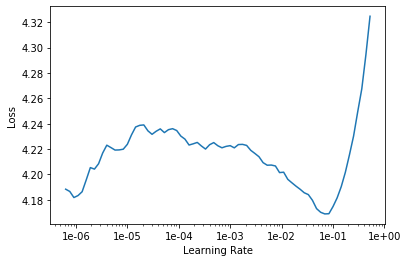

In [0]:
learn.recorder.plot(skip_end=15) # визуализируем лосс x скорость обучения для выбора нужного диапазона

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) # запускаем дообучение на один цикл

epoch,train_loss,valid_loss,accuracy,time
0,4.004040,3.757488,0.294970,00:13


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

Можем также продолжить fine-tuning, разморозив всю модель (обучение продлится несколько часов).

In [0]:
learn.unfreeze() # разморозка

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7)) # обучение целиком

epoch,train_loss,valid_loss,accuracy
1,3.958489,3.885153,0.310139
2,3.871605,3.814774,0.319821
3,3.804589,3.767966,0.325793
4,3.771248,3.729666,0.330175
5,3.677534,3.699244,0.333532
6,3.644140,3.674071,0.336564
7,3.603597,3.655099,0.338747
8,3.524271,3.641979,0.340568
9,3.505476,3.636194,0.341246
10,3.461232,3.635963,0.341371


In [0]:
learn.save('fine_tuned')

Теперь проверим, насколько хороша наша модель -- посмотрим, что она будет предсказывать на основании нескольких первых слов.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because" # первые слова, по которым делается прогноз; вариант для позитивного отзыва
# TEXT = "I displease this movie because" # проверка для негативного отзыва
N_WORDS = 40 # количество последующих слов в прогнозе модели
N_SENTENCES = 2 # количество фраз в прогнозе модели

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES))) # генерируем текст отзыва

I liked this movie because i thought it would make a movie that i cried . This is not so much a movie as i 've seen . It is a serious movie , but it 's a cheesy film . It
I liked this movie because i had the film i was trying to find in i Love You Again , but i was in my hands - on the screen with my sister Anne and she was the outstanding actress .


Сохранить в заключение требуется не только модель, но и её **кодировщик** (**encoder**, модуль, который отвечает за создание и обновление внутреннего состояния рекуррентной сети), чтобы не выполнять этот шаг каждый раз заново.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Классификатор

Наконец, мы хотим заняться классификацией оригинальных отзывов.

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab) # настраиваем доступ к сырому датасету
             .split_by_folder(valid='test') # явно укажем тестовую выборку, которая уже размечена
             .label_from_folder(classes=['neg', 'pos']) # возьмём готовую разметку
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older",neg
"xxbos * * * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . * * * \n \n xxmaj before i begin , i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that",neg
"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n \n xxmaj this xxmaj serial is one of my own personal favourites , and as previously stated , it is one of the xxmaj top 5 xxmaj sound xxmaj serials . xxmaj oddly enough , this",pos
"xxbos xxmaj pier xxmaj paolo xxmaj pasolini , or xxmaj pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated xxmaj european xxmaj marxist director - and they are thick on the ground . xxmaj how anyone can see "" art "" in this messy , cheap sex - romp concoction is",neg


Подготовим модель, которая будет классифицировать наши размеченные обзоры.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc') # подгружаем ранее сохранённый кодировщик для языковой модели

In [0]:
learn.lr_find()

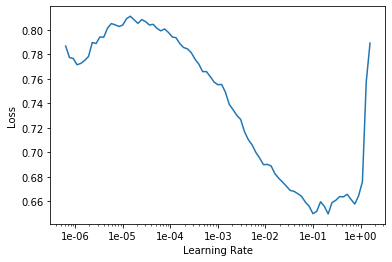

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.424404,0.345032,0.849000,04:31


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2) # размораживаем все слои, кроме двух последних
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.302241,0.230162,0.906920,05:16


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3) # размораживаем все слои, кроме трёх последних
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.244231,0.189091,0.927440,07:09


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze() # размораживаем всё
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.217697,0.174612,0.932720,10:17
1,0.209001,0.173497,0.934000,10:28


In [0]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([6.6803e-08, 1.0000e+00]))

## Задание

Выполните вышеописанные шаги (использование языковой модели и классификатора) для генерации и классификации текстов на русском языке. Для этого потребуется языковая модель **ULMFit**, много наработок по которой можно нагуглить запросом `Russian ULMFit`.

